<a href="https://colab.research.google.com/github/azizamirsaidova/content-moderation/blob/main/src/Content_Moderation_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Content Moderation Classifier Tutorial**

**Goal:**
We aim to build a content moderation classifier that:

1. Classifies harmful content into pre-defined categories using benchmark data and
a machine learning model.
2. Uses LLM-based prompt engineering to classify harmful content dynamically.

## **Setup**

**Step 1:** Import Libraries and Install Necessary Packages
To start, install required libraries (e.g., transformers, sklearn, torch).

In [1]:
!pip install transformers
!pip install sklearn torch pandas
!pip install wandb -qU

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
# # Initialize wandb
# import wandb
# wandb.init(project="content-classifier", name="bert")

# **Part 1: Content Classifier**

### **Step 2: Load Public Benchmark Dataset**
[Jigsaw Unintended Bias in Toxicity Classification Data](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview)

For demonstration purposes, let’s load a sample dataset that contains harmful content labeled with categories.

In [4]:
import json
import pandas as pd

data_path = '/content/train.jsonl'
data = []

with open(data_path, 'r') as file:
    for line in file:
        try:
            entry = json.loads(line)
            data.append({'text': entry.get('text'), 'label': entry.get('label')})
        except json.JSONDecodeError as e:
            print(f"Skipping line due to error: {e}")
df = pd.DataFrame(data, columns=['text', 'label'])
df = df[['text', 'label']].head(10)
df.head()


,text,label
0,theres not enough going on around here for air...,0
1,How about ZERO,0
2,Her name is still floating? Might I suggest f...,0
3,Stop by So Cold at MFNW/Project Pabst! It'll m...,0
4,"Nobody awake on the bridge, no lookouts ,,no r...",0


In [5]:
print(f"Dataset shape: {df.shape}")
print("\nColumn types:\n", df.dtypes)
df.sample(5)


Dataset shape: (10, 2)

Column types:
 text     object
label     int64
dtype: object


,text,label
2,Her name is still floating? Might I suggest f...,0
7,"States don't grow economies, cities grow econo...",0
0,theres not enough going on around here for air...,0
6,I'm sure Hawaiian can put Southwest out of bus...,0
1,How about ZERO,0


#### **Data Analysis**

Label Distribution.


Label Distribution:
 label
0    10
Name: count, dtype: int64


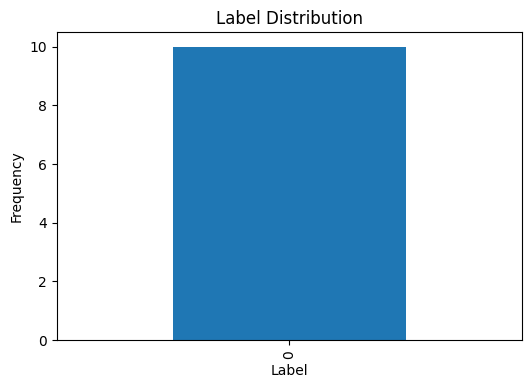

In [6]:
import matplotlib.pyplot as plt
label_counts = df['label'].value_counts()
print("\nLabel Distribution:\n", label_counts)
plt.figure(figsize=(6,4))
label_counts.plot(kind='bar')
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.show()


Text Length Analysis


Text Length Statistics:
 count     10.000000
mean     180.000000
std      176.381531
min       14.000000
25%       81.250000
50%       98.000000
75%      250.000000
max      552.000000
Name: text_length, dtype: float64


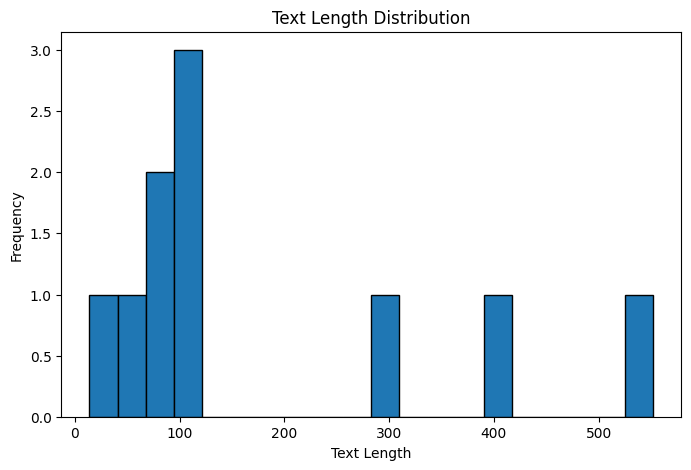

In [7]:
df['text_length'] = df['text'].apply(len)
print("\nText Length Statistics:\n", df['text_length'].describe())
plt.figure(figsize=(8,5))
plt.hist(df['text_length'], bins=20, edgecolor='black')
plt.title("Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()


Check missing or duplicate values.

In [8]:
missing_values = df.isnull().sum()
print("\nMissing Values:\n", missing_values)

duplicate_texts = df.duplicated(subset='text').sum()
print(f"\nNumber of duplicate texts: {duplicate_texts}")



Missing Values:
 text           0
label          0
text_length    0
dtype: int64

Number of duplicate texts: 0


### **Step 3: Data Preparation**

Split the data into training and testing sets.

In [9]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42
)


### **Step 4: Tokenization**
Use a transformer model for classification. We'll tokenize the text data.

In [10]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### **Step 5: Convert Labels to Numeric Format**
Transform category labels to integers.

In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)

### **Step 6: Create DataLoader**
Prepare data for PyTorch model training.

In [12]:
from torch.utils.data import DataLoader, TensorDataset

# Convert to tensors
train_dataset = TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),  # Include attention mask
    torch.tensor(train_labels)
)
test_dataset = TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask']),  # Include attention mask
    torch.tensor(test_labels)
)


# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


### **Step 7: Build and Train Model**
Load a pretrained model for sequence classification.

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification
import wandb
from sklearn.metrics import classification_report, accuracy_score


wandb.init(project="content-moderation", config={
    "model_name": "distilbert-base-uncased",
    "epochs": 3,
    "learning_rate": 1e-5,
})

# Model and optimizer setup
model = AutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=len(label_encoder.classes_)
).to("cuda")
model.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=wandb.config.learning_rate)

for epoch in range(wandb.config.epochs):
    model.train()
    running_loss = 0.0
    for i, batch in enumerate(train_loader):
        inputs, masks, labels = [x.to("cuda") for x in batch]
        optimizer.zero_grad()

        # Forward pass with inputs and attention masks
        outputs = model(input_ids=inputs, attention_mask=masks)

        # Compute and backpropagate loss
        loss = torch.nn.functional.cross_entropy(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss for logging
        running_loss += loss.item()

        # Log loss for every 10 batches
        if i % 10 == 0:
            wandb.log({"batch_loss": loss.item(), "epoch": epoch})

    # Log the average loss per epoch to W&B
    avg_loss = running_loss / len(train_loader)
    wandb.log({"epoch_loss": avg_loss, "epoch": epoch})
    print(f"Epoch [{epoch + 1}/{wandb.config.epochs}], Loss: {avg_loss:.4f}")

model.eval()

predictions = []
true_labels = []

# Evaluation loop with attention masks and GPU support
with torch.no_grad():
    for batch in test_loader:
        inputs, masks, labels = [x.to("cuda") for x in batch]

        # Forward pass with attention mask
        outputs = model(input_ids=inputs, attention_mask=masks)

        # Get predictions and true labels
        logits = outputs.logits
        preds = torch.argmax(logits, axis=1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())

target_names = [str(label) for label in label_encoder.classes_]

# # Calculate and print classification report
# report = classification_report(true_labels, predictions, target_names=label_encoder.classes_, output_dict=True)
# print(classification_report(true_labels, predictions, target_names=label_encoder.classes_))

wandb.log({
    "eval_accuracy": accuracy_score(true_labels, predictions),
    # "classification_report": report
})

wandb.finish()


### **Next Steps:**
1. Improve the model performance (i.e run on all data, add more parameters)
2. Experiment with other models (i.e https://huggingface.co/FacebookAI/roberta-base)
